# Imports

In [5]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict, LeaveOneOut, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Dados

In [6]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'Partial Components Analysis'

file_path_raw_cal = base_path / 'RAW_calibration.xlsx'
file_path_msc_cal = base_path / 'MSC_calibration.xlsx'
file_path_snv_cal = base_path / 'SNV_calibration.xlsx'
file_path_sg_cal = base_path / 'SG_calibration.xlsx'

df_raw_cal = pd.read_excel(file_path_raw_cal)
df_msc_cal = pd.read_excel(file_path_msc_cal)
df_snv_cal = pd.read_excel(file_path_snv_cal)
df_sg_cal = pd.read_excel(file_path_sg_cal)

file_path_raw_val = base_path / 'RAW_validation.xlsx'
file_path_msc_val = base_path / 'MSC_validation.xlsx'
file_path_snv_val = base_path / 'SNV_validation.xlsx'
file_path_sg_val = base_path / 'SG_validation.xlsx'

df_raw_val = pd.read_excel(file_path_raw_val)
df_msc_val = pd.read_excel(file_path_msc_val)
df_snv_val = pd.read_excel(file_path_snv_val)
df_sg_val = pd.read_excel(file_path_sg_val)

In [7]:
X_test, y_test = df_msc_val.iloc[:,6:], df_msc_val['SST'].values
X_train, y_train = df_msc_cal.iloc[:,6:], df_msc_cal['SST'].values

# Teste

In [8]:
# Definir o pipeline
pipeline = make_pipeline(
    StandardScaler(),  # Normalização dos dados
    RandomForestRegressor(
        random_state=1  # Semente aleatória para reprodutibilidade
    )
)

# Definir os parâmetros para o GridSearch
param_grid = {
    'randomforestregressor__n_estimators': [50, 80],  # Número de árvores
    'randomforestregressor__max_features': ['sqrt', 'log2'],  # Número de características consideradas para cada divisão
    'randomforestregressor__max_depth': [20, 30, 40],  # Profundidade máxima da árvore
    'randomforestregressor__min_samples_split': [2, 5],  # Número mínimo de amostras necessárias para dividir um nó
    'randomforestregressor__min_samples_leaf': [1, 2],  # Número mínimo de amostras necessárias em um nó folha
    'randomforestregressor__bootstrap': [True, False],  # Amostragem bootstrap
}

# Definir o GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # Usando MAE como métrica de avaliação
    cv=175,  # Validação cruzada com 5 folds
    n_jobs=-1,  # Utiliza todos os processadores disponíveis
    verbose=3  # Mostra detalhes do processo
)

# Treinar o GridSearchCV
grid_search.fit(X_train, y_train)

# Resultados do GridSearch
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

# Fazer previsões no conjunto de teste usando o melhor modelo encontrado
y_pred = grid_search.predict(X_test)

# Calcular e exibir as métricas de desempenho
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nResultados no conjunto de teste:")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R² (Coeficiente de Determinação): {r2:.4f}")


Fitting 175 folds for each of 96 candidates, totalling 16800 fits


Melhores parâmetros encontrados:
{'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 20, 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 80}

Resultados no conjunto de teste:
MAE (Mean Absolute Error): 0.9844
RMSE (Root Mean Squared Error): 1.1926
R² (Coeficiente de Determinação): 0.6788


In [3]:
def testrfr(X_cal, y_cal, X_val, y_val, filter, attribute):
    # Função para calcular as métricas
    def calculate_metrics(y_true, y_pred):
        correlation_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mean_y_true = np.mean(y_true)
        relative_absolute_error = 100 * (mae / np.mean(np.abs(y_true - mean_y_true)))
        root_relative_squared_error = 100 * (rmse / np.std(y_true))

        return {
            "Correlation coefficient": correlation_coefficient,
            "Mean absolute error": mae,
            "Root mean squared error": rmse,
            "Relative absolute error": relative_absolute_error,
            "Root relative squared error": root_relative_squared_error,
            "Total Number of Instances": len(y_true)
        }

    def display_metrics(title, metrics):
        print(f"\n=== {title} ===")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    # Definir variáveis de treino e teste para o atributo atual
    X_train, y_train = X_cal, y_cal
    X_test, y_test = X_val, y_val

    # Criar o pipeline
    pipeline = make_pipeline(
        StandardScaler(),  # Normalização dos dados
        RandomForestRegressor(
            n_estimators=50,  # Número de árvores
            max_features='sqrt', # Usar raiz quadrada do número de características
            max_depth=20,    # Profundidade das árvores
            min_samples_split=2,  # Número mínimo de amostras necessárias para dividir um nó
            min_samples_leaf=1,   # Número mínimo de amostras necessárias em um nó folha
            bootstrap=True,    # Usar amostragem bootstrap
            oob_score=False,   # Não usar amostragem fora da bolsa
            random_state=1     # Semente aleatória
        )
    )

    # Treinar o modelo
    pipeline.fit(X_train, y_train)

    # Fazer previsões no conjunto de treinamento
    y_train_pred = pipeline.predict(X_train)
    training_metrics = calculate_metrics(y_train, y_train_pred)
    display_metrics("Training Metrics", training_metrics)

    # Validação cruzada Leave-One-Out (LOO)
    loo = LeaveOneOut()
    y_train_cv = cross_val_predict(pipeline, X_train, y_train, cv=loo)
    cv_metrics = calculate_metrics(y_train, y_train_cv)
    display_metrics("Cross-Validation Metrics", cv_metrics)

    # Avaliação final no conjunto de teste
    y_pred_val = pipeline.predict(X_test)
    validation_metrics = calculate_metrics(y_test, y_pred_val)
    display_metrics("Validation Metrics", validation_metrics)

    results = []

    for metric, value in training_metrics.items():
        results.append({'Métrica': f'Training {metric}', 'Valor': value})
    
    for metric, value in cv_metrics.items():
        results.append({'Métrica': f'CV {metric}', 'Valor': value})
    
    for metric, value in validation_metrics.items():
        results.append({'Métrica': f'Validation {metric}', 'Valor': value})

    # Converter os resultados para um DataFrame
    results_df = pd.DataFrame(results)
    
    def plot_regression_comparison(y_train, y_pred_train, y_pred_cv):    
        slope_pred, offset_pred = np.polyfit(y_train, y_pred_train, 1)
        rmse_pred = np.sqrt(mean_squared_error(y_train, y_pred_train))
        r2_pred = r2_score(y_train, y_pred_train)
        
        slope_opt, offset_opt = np.polyfit(y_train, y_pred_cv, 1)
        rmse_opt = np.sqrt(mean_squared_error(y_train, y_pred_cv))
        r2_opt = r2_score(y_train, y_pred_cv)
        
        metrics_dict = pd.DataFrame({
        'Y': ['Referência', 'Predição'],
        'Slope': [slope_opt,slope_pred],
        'Offset': [offset_opt, offset_pred],
        'RMSE': [rmse_opt, rmse_pred],
        'R²': [r2_opt, r2_pred]
        })
        
        plt.figure(figsize=(10, 6))
        
        # Scatter plot for reference values
        plt.scatter(y_train, y_pred_train, color='blue', label='Reference', marker='o', alpha=0.7)
        
        # Scatter plot for predicted values
        plt.scatter(y_train, y_pred_cv, color='red', label='Predicted', marker='o', alpha=0.7)
        
        plt.xlabel("Reference")
        plt.ylabel("Predicted")
        plt.title("Reference vs. Predicted")
        plt.grid(True)
        plt.text(0.05, 0.95, f'Reference - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nPredicted - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
                transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
        plt.legend(loc='lower right')
        plt.show()

    # Plotar comparação entre valores reais e preditos
    plot_regression_comparison(y_train, y_train_pred, y_train_cv)
    
    def plot_test_predictions(y_true_test, y_pred_test):
        # Calcular slope, offset, R² e RMSE
        model = LinearRegression().fit(y_pred_test.reshape(-1, 1), y_true_test)
        slope = model.coef_[0]
        offset = model.intercept_
        y_pred_line = model.predict(np.array([y_true_test.min(), y_true_test.max()]).reshape(-1, 1))
        r2 = r2_score(y_true_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_test, y_true_test, color='green', label='Dados')
        plt.plot([y_true_test.min(), y_true_test.max()], y_pred_line, color='blue', linestyle='--', label='Linha de Regressão')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.title('Predições no Conjunto de Teste')
        plt.legend()
        plt.text(0.05, 0.95, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
                transform=plt.gca().transAxes, verticalalignment='top')
        plt.tight_layout()
        plt.show()

    # Plotar as predições do conjunto de teste
    plot_test_predictions(y_test, y_pred_val)
    
    return results_df


# Algoritmo

In [33]:
def RFR(X_cal, y_cal, X_val, y_val, filter, attribute):
    # Função para calcular as métricas
    def calculate_metrics(y_true, y_pred):
        # Calcular as métricas adicionais
        model = LinearRegression().fit(y_pred.reshape(-1, 1), y_true)
        slope = model.coef_[0]
        offset = model.intercept_
        r2 = r2_score(y_true, y_pred)

        # Calcular as métricas já existentes
        correlation_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mean_y_true = np.mean(y_true)
        relative_absolute_error = 100 * (mae / np.mean(np.abs(y_true - mean_y_true)))
        root_relative_squared_error = 100 * (rmse / np.std(y_true))

        return {
            "Correlation coefficient": correlation_coefficient,
            "Mean absolute error": mae,
            "Root mean squared error": rmse,
            "Relative absolute error": relative_absolute_error,
            "Root relative squared error": root_relative_squared_error,
            "Slope": slope,
            "Offset": offset,
            "R²": r2,
            "Total Number of Instances": len(y_true)
        }

    def display_metrics(title, metrics):
        print(f"=== {title} ===")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    # Definir variáveis de treino e teste para o atributo atual
    X_train, y_train = X_cal, y_cal
    X_test, y_test = X_val, y_val

    # Criar o pipeline
    pipeline = make_pipeline(
        StandardScaler(),  # Normalização dos dados
        RandomForestRegressor(
            n_estimators=80,
            max_features='log2', # Usar raiz quadrada do número de características
            max_depth=20,    # Profundidade das árvores
            min_samples_split=5,  # Número mínimo de amostras necessárias para dividir um nó
            min_samples_leaf=1,   # Número mínimo de amostras necessárias em um nó folha
            bootstrap=True,    # Usar amostragem bootstrap
            oob_score=False,   # Não usar amostragem fora da bolsa
            random_state=1     # Semente aleatória
        )
    )

    # Treinar o modelo
    pipeline.fit(X_train, y_train)

    # Fazer previsões no conjunto de treinamento
    y_train_pred = pipeline.predict(X_train)
    training_metrics = calculate_metrics(y_train, y_train_pred)
    display_metrics("Training Metrics", training_metrics)

    # Validação cruzada Leave-One-Out (LOO)
    loo = LeaveOneOut()
    y_train_cv = cross_val_predict(pipeline, X_train, y_train, cv=loo)
    cv_metrics = calculate_metrics(y_train, y_train_cv)
    display_metrics("Cross-Validation Metrics", cv_metrics)

    # Avaliação final no conjunto de teste
    y_pred_val = pipeline.predict(X_test)
    validation_metrics = calculate_metrics(y_test, y_pred_val)
    display_metrics("Validation Metrics", validation_metrics)

    results = []

    for metric, value in training_metrics.items():
        results.append({'Métrica': f'Training {metric}', 'Valor': value})
    
    for metric, value in cv_metrics.items():
        results.append({'Métrica': f'CV {metric}', 'Valor': value})
    
    for metric, value in validation_metrics.items():
        results.append({'Métrica': f'Validation {metric}', 'Valor': value})

    # Converter os resultados para um DataFrame
    results_df = pd.DataFrame(results)
    
    def plot_regression_comparison(y_train, y_pred_train, y_pred_cv):    
        slope_pred, offset_pred = np.polyfit(y_train, y_pred_train, 1)
        rmse_pred = np.sqrt(mean_squared_error(y_train, y_pred_train))
        r2_pred = r2_score(y_train, y_pred_train)
        
        slope_opt, offset_opt = np.polyfit(y_train, y_pred_cv, 1)
        rmse_opt = np.sqrt(mean_squared_error(y_train, y_pred_cv))
        r2_opt = r2_score(y_train, y_pred_cv)
        
        metrics_dict = pd.DataFrame({
        'Y': ['Referência', 'Predição'],
        'Slope': [slope_opt,slope_pred],
        'Offset': [offset_opt, offset_pred],
        'RMSE': [rmse_opt, rmse_pred],
        'R²': [r2_opt, r2_pred]
        })
        
        plt.figure(figsize=(10, 6))
        
        # Scatter plot for reference values
        plt.scatter(y_train, y_pred_train, color='blue', label='Reference', marker='o', alpha=0.7)
        
        # Scatter plot for predicted values
        plt.scatter(y_train, y_pred_cv, color='red', label='Predicted', marker='o', alpha=0.7)
        
        plt.xlabel("Reference")
        plt.ylabel("Predicted")
        plt.title(f"{filter + " - " + attribute}:Reference vs. Predicted")
        plt.grid(True)
        plt.text(0.05, 0.95, f'Predicted - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nReference - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
                transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
        plt.legend(loc='lower right')
        plt.show()

    # Plotar comparação entre valores reais e preditos
    plot_regression_comparison(y_train, y_train_pred, y_train_cv)
    
    def plot_test_predictions(y_true_test, y_pred_test):
        # Calcular slope, offset, R² e RMSE
        model = LinearRegression().fit(y_pred_test.reshape(-1, 1), y_true_test)
        slope = model.coef_[0]
        offset = model.intercept_
        y_pred_line = model.predict(np.array([y_true_test.min(), y_true_test.max()]).reshape(-1, 1))
        r2 = r2_score(y_true_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_test, y_true_test, color='green', label='Dados')
        plt.plot([y_true_test.min(), y_true_test.max()], y_pred_line, color='blue', linestyle='--', label='Linha de Regressão')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.title('Predições no Conjunto de Teste')
        plt.legend()
        plt.text(0.05, 0.95, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
                transform=plt.gca().transAxes, verticalalignment='top')
        plt.tight_layout()
        plt.show()

    # Plotar as predições do conjunto de teste
    plot_test_predictions(y_test, y_pred_val)
    
    return results_df


# Ajusta saída

In [14]:
def save_results(filter, attribute, results_df):
    # Definir o nome do arquivo com base no filtro e atributo
    filename = f'random_forest_results.xlsx'
    
    # Definir o nome da aba
    sheet_name = f'{filter}_{attribute}'
    
    # Usar ExcelWriter para adicionar ou criar o arquivo e a nova aba
    with pd.ExcelWriter(filename, engine='openpyxl', mode='a' if os.path.exists(filename) else 'w') as writer:
        results_df.to_excel(writer, sheet_name=sheet_name, index=False)
    
    print(f'Resultados salvos em: {filename}, na aba: {sheet_name}')


# MSC - RFR

=== Training Metrics ===
Correlation coefficient: 0.9715
Mean absolute error: 0.5330
Root mean squared error: 0.6756
Relative absolute error: 24.1397
Root relative squared error: 25.4338
Slope: 1.1048
Offset: -1.4799
R²: 0.9353
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.8256
Mean absolute error: 1.1969
Root mean squared error: 1.4995
Relative absolute error: 54.2072
Root relative squared error: 56.4474
Slope: 1.0163
Offset: -0.2399
R²: 0.6814
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.8255
Mean absolute error: 0.9844
Root mean squared error: 1.1926
Relative absolute error: 57.1159
Root relative squared error: 56.6724
Slope: 0.9410
Offset: 0.8331
R²: 0.6788
Total Number of Instances: 75.0000


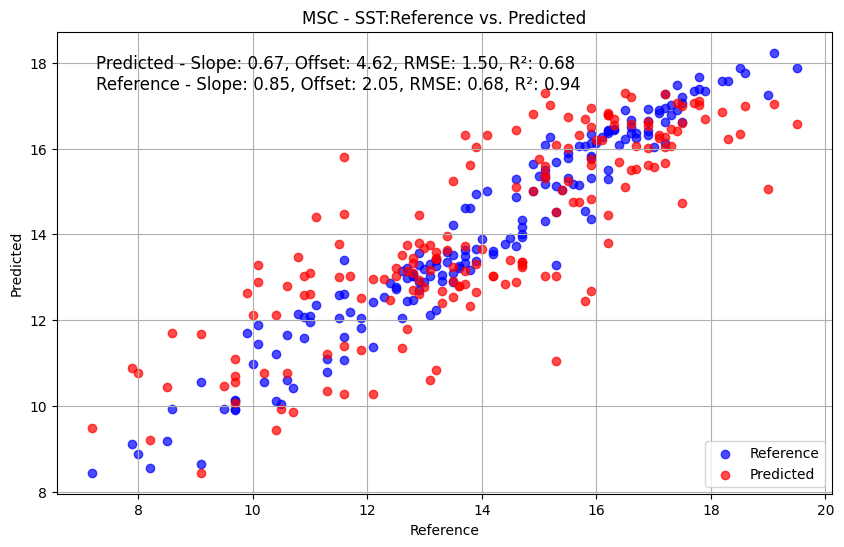

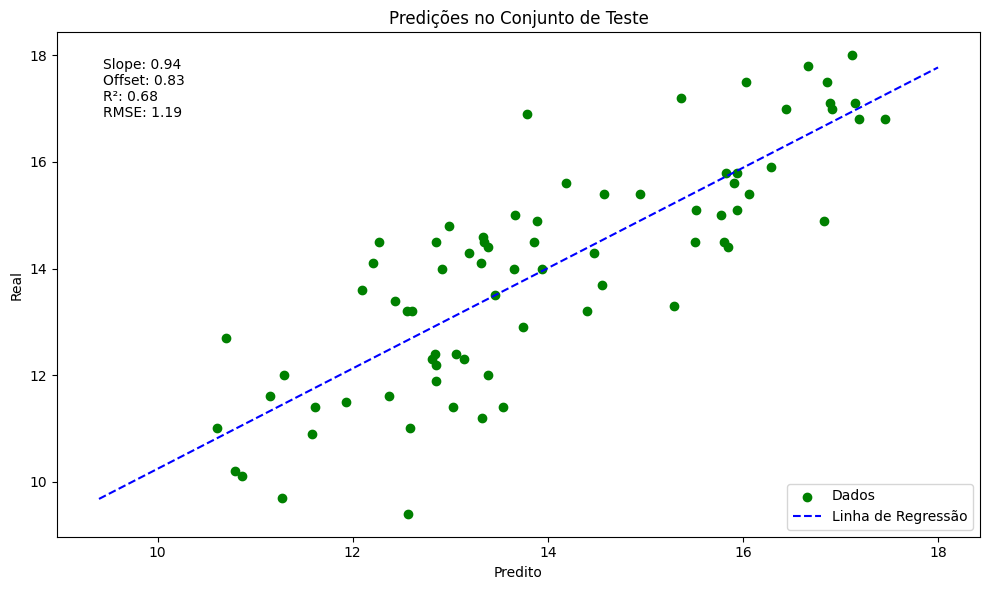

Resultados salvos em: random_forest_results.xlsx, na aba: MSC_SST


In [40]:
results_msc_sst = RFR(df_msc_cal.iloc[:, 6:], df_msc_cal['SST'].values, df_msc_val.iloc[:, 6:], df_msc_val['SST'].values, 'MSC', 'SST')
save_results('MSC', 'SST', results_msc_sst)

=== Training Metrics ===
Correlation coefficient: 0.9429
Mean absolute error: 0.1152
Root mean squared error: 0.2167
Relative absolute error: 25.5030
Root relative squared error: 36.9458
Slope: 1.2036
Offset: -0.2326
R²: 0.8635
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.6581
Mean absolute error: 0.2595
Root mean squared error: 0.4420
Relative absolute error: 57.4281
Root relative squared error: 75.3804
Slope: 0.9566
Offset: 0.0368
R²: 0.4318
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.7673
Mean absolute error: 0.2043
Root mean squared error: 0.2879
Relative absolute error: 57.4648
Root relative squared error: 65.8272
Slope: 0.8851
Offset: 0.0835
R²: 0.5667
Total Number of Instances: 75.0000


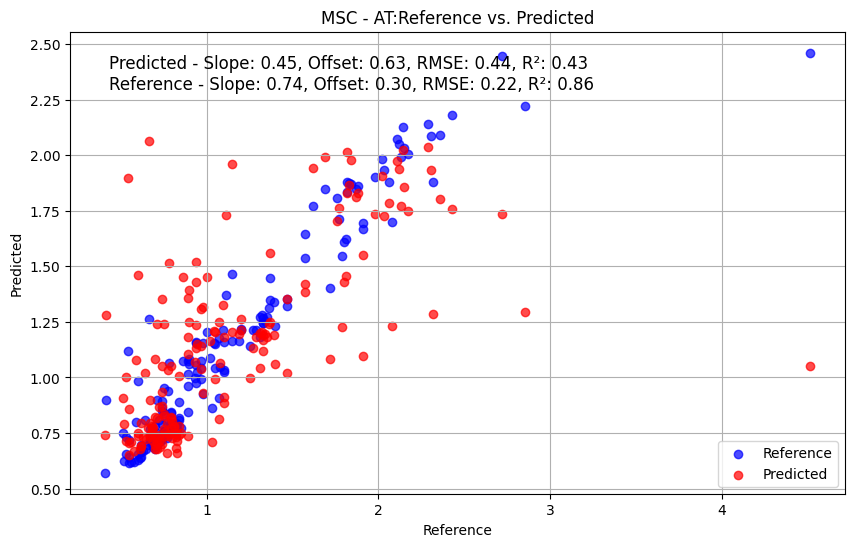

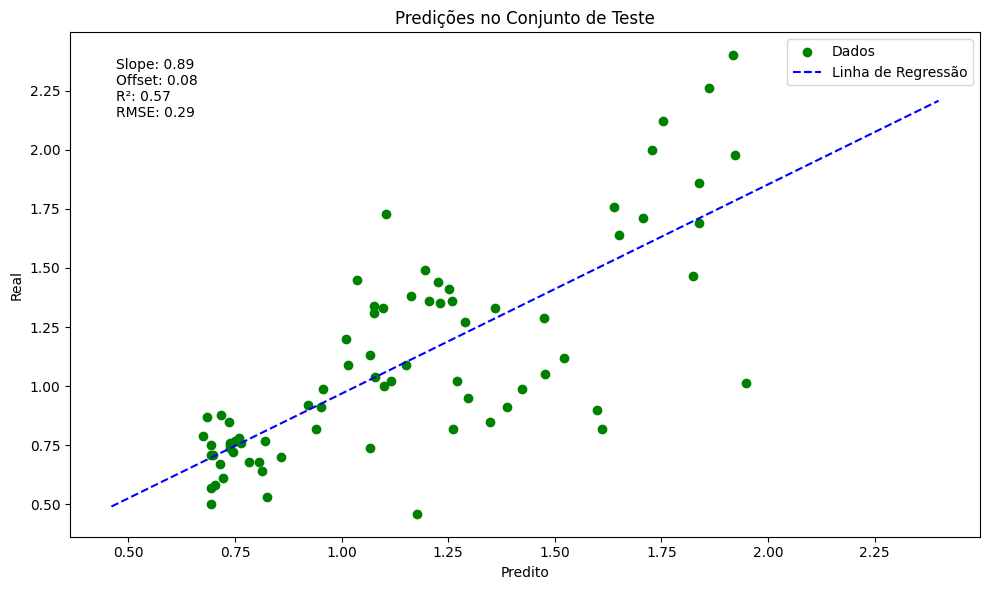

Resultados salvos em: random_forest_results.xlsx, na aba: MSC_AT


In [41]:
results_msc_at = RFR(df_msc_cal.iloc[:, 6:], df_msc_cal['AT'].values, df_msc_val.iloc[:, 6:], df_msc_val['AT'].values, 'MSC', 'AT')
save_results('MSC', 'AT', results_msc_at)

=== Training Metrics ===
Correlation coefficient: 0.9611
Mean absolute error: 0.0628
Root mean squared error: 0.1051
Relative absolute error: 26.1739
Root relative squared error: 34.0922
Slope: 1.2624
Offset: -0.8651
R²: 0.8838
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.5716
Mean absolute error: 0.1527
Root mean squared error: 0.2534
Relative absolute error: 63.6350
Root relative squared error: 82.1625
Slope: 0.9620
Offset: 0.1141
R²: 0.3249
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.5741
Mean absolute error: 0.1589
Root mean squared error: 0.2253
Relative absolute error: 67.4452
Root relative squared error: 85.5068
Slope: 0.7009
Offset: 0.9894
R²: 0.2689
Total Number of Instances: 75.0000


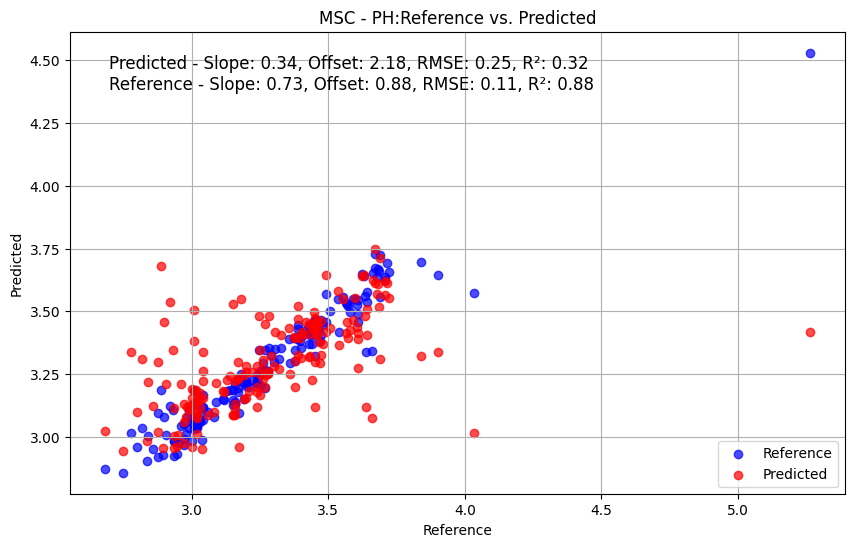

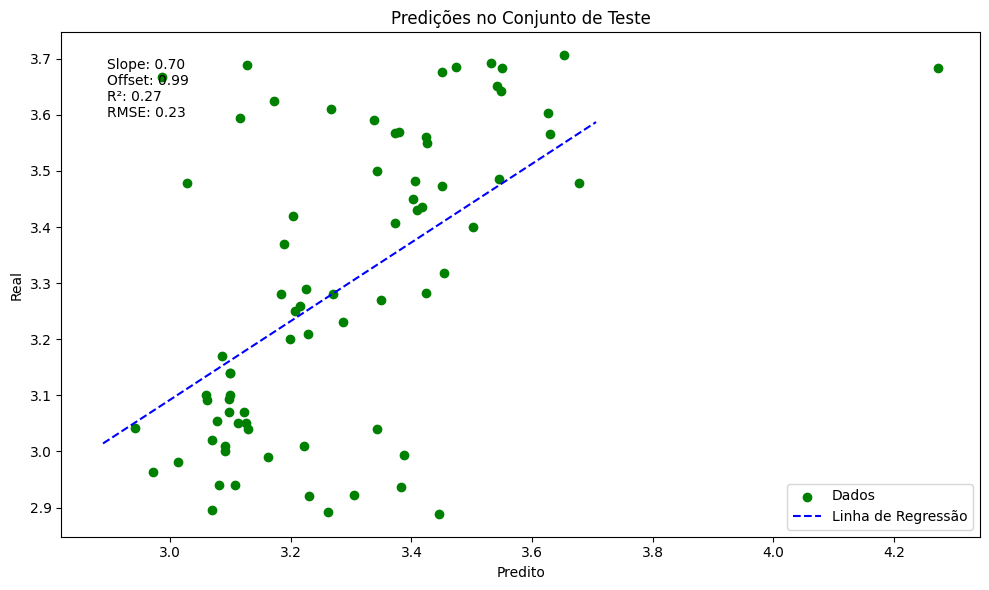

Resultados salvos em: random_forest_results.xlsx, na aba: MSC_PH


In [42]:
results_msc_ph = RFR(df_msc_cal.iloc[:, 6:], df_msc_cal['PH'].values, df_msc_val.iloc[:, 6:], df_msc_val['PH'].values, 'MSC', 'PH')
save_results('MSC', 'PH', results_msc_ph)


=== Training Metrics ===
Correlation coefficient: 0.9574
Mean absolute error: 26.9574
Root mean squared error: 33.8104
Relative absolute error: 32.3738
Root relative squared error: 32.8990
Slope: 1.1964
Offset: -101.7813
R²: 0.8918
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.6700
Mean absolute error: 61.9117
Root mean squared error: 76.3708
Relative absolute error: 74.3514
Root relative squared error: 74.3123
Slope: 0.9522
Offset: 24.6854
R²: 0.4478
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.6984
Mean absolute error: 46.6439
Root mean squared error: 57.2132
Relative absolute error: 73.4877
Root relative squared error: 74.0571
Slope: 0.8456
Offset: 68.3149
R²: 0.4516
Total Number of Instances: 75.0000


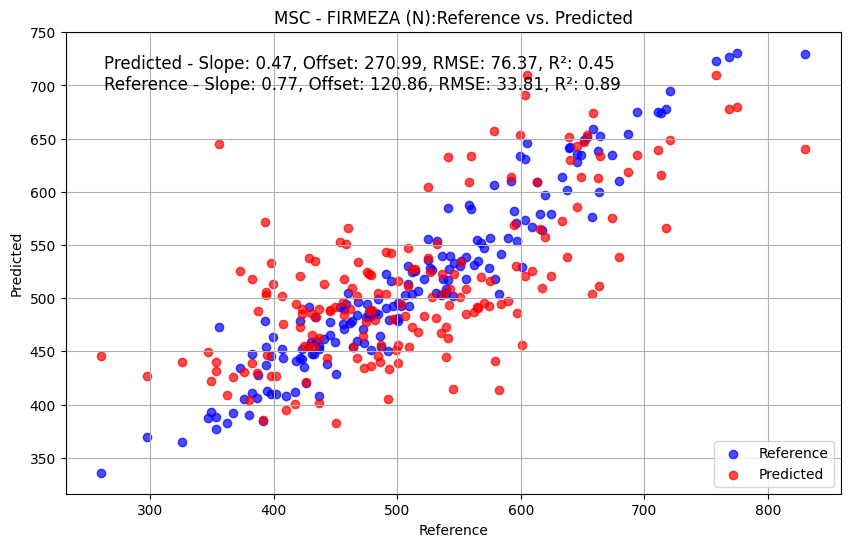

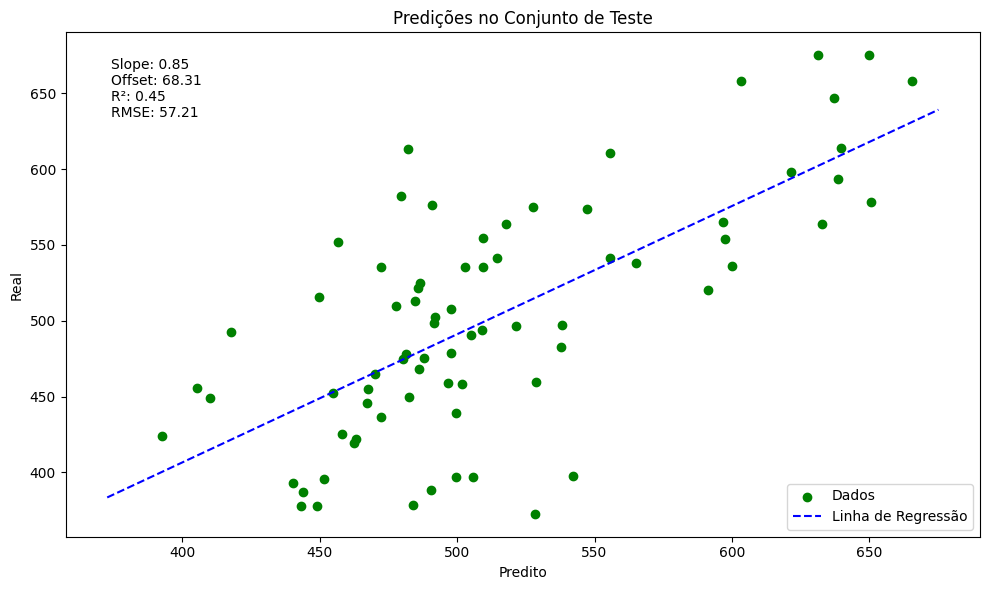

Resultados salvos em: random_forest_results.xlsx, na aba: MSC_FIRMEZA


In [43]:
results_msc_f = RFR(df_msc_cal.iloc[:, 6:], df_msc_cal['FIRMEZA (N)'].values, df_msc_val.iloc[:, 6:], df_msc_val['FIRMEZA (N)'].values, 'MSC', 'FIRMEZA (N)')
save_results('MSC', 'FIRMEZA', results_msc_f)

=== Training Metrics ===
Correlation coefficient: 0.9640
Mean absolute error: 0.5464
Root mean squared error: 0.9346
Relative absolute error: 22.1146
Root relative squared error: 29.0524
Slope: 1.1378
Offset: -2.1209
R²: 0.9156
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.7743
Mean absolute error: 1.2492
Root mean squared error: 2.0357
Relative absolute error: 50.5621
Root relative squared error: 63.2827
Slope: 1.0024
Offset: -0.0228
R²: 0.5995
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.8309
Mean absolute error: 0.9710
Root mean squared error: 1.3202
Relative absolute error: 54.6943
Root relative squared error: 60.9206
Slope: 0.7735
Offset: 3.3618
R²: 0.6289
Total Number of Instances: 75.0000


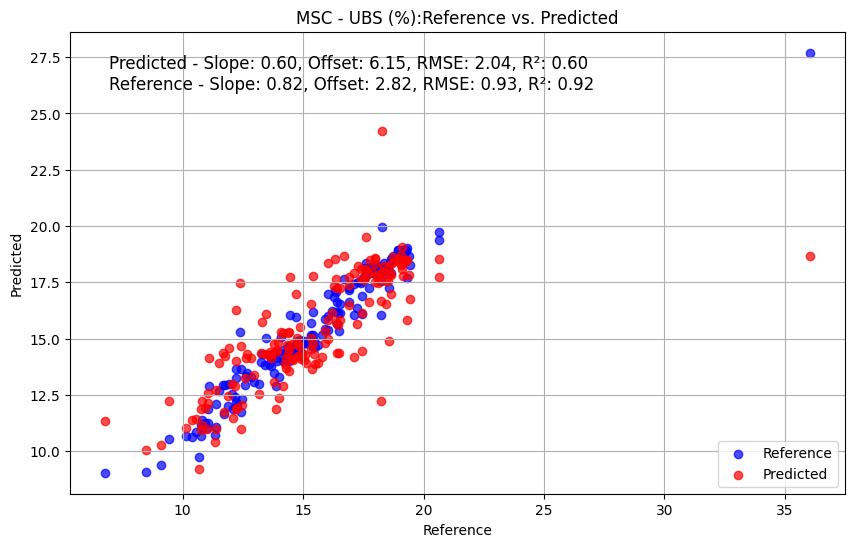

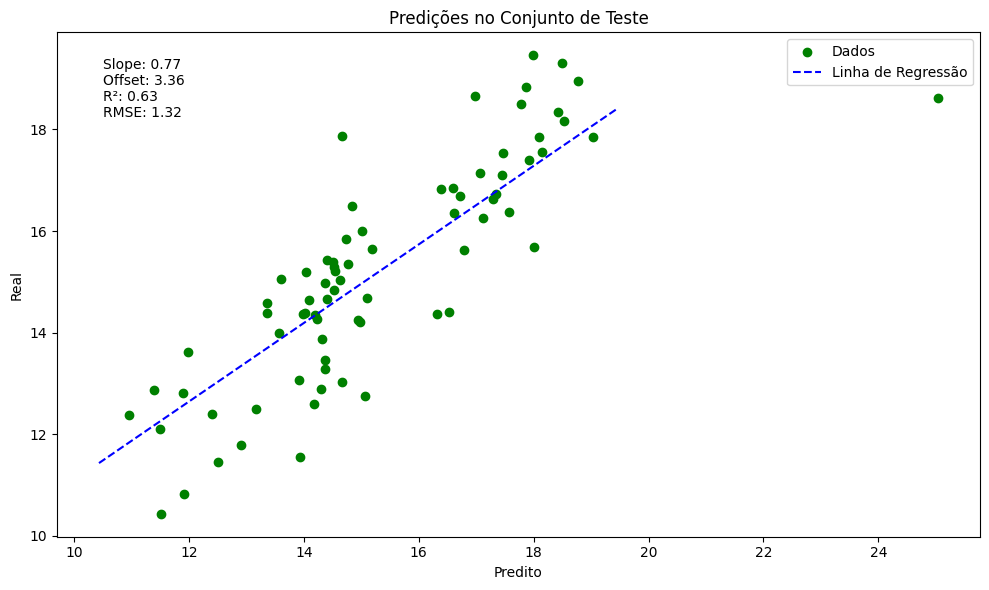

Resultados salvos em: random_forest_results.xlsx, na aba: MSC_UBS


In [44]:
results_msc_ubs = RFR(df_msc_cal.iloc[:, 6:], df_msc_cal['UBS (%)'].values, df_msc_val.iloc[:, 6:], df_msc_val['UBS (%)'].values, 'MSC', 'UBS (%)')
save_results('MSC', 'UBS', results_msc_ubs)

# SNV - RFR

=== Training Metrics ===
Correlation coefficient: 0.9718
Mean absolute error: 0.5040
Root mean squared error: 0.6511
Relative absolute error: 23.5463
Root relative squared error: 25.0175
Slope: 1.0937
Offset: -1.3069
R²: 0.9374
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.8291
Mean absolute error: 1.1682
Root mean squared error: 1.4551
Relative absolute error: 54.5729
Root relative squared error: 55.9062
Slope: 0.9952
Offset: 0.0661
R²: 0.6874
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.8535
Mean absolute error: 0.9524
Root mean squared error: 1.2070
Relative absolute error: 51.2368
Root relative squared error: 53.7252
Slope: 0.8771
Offset: 1.6348
R²: 0.7114
Total Number of Instances: 75.0000


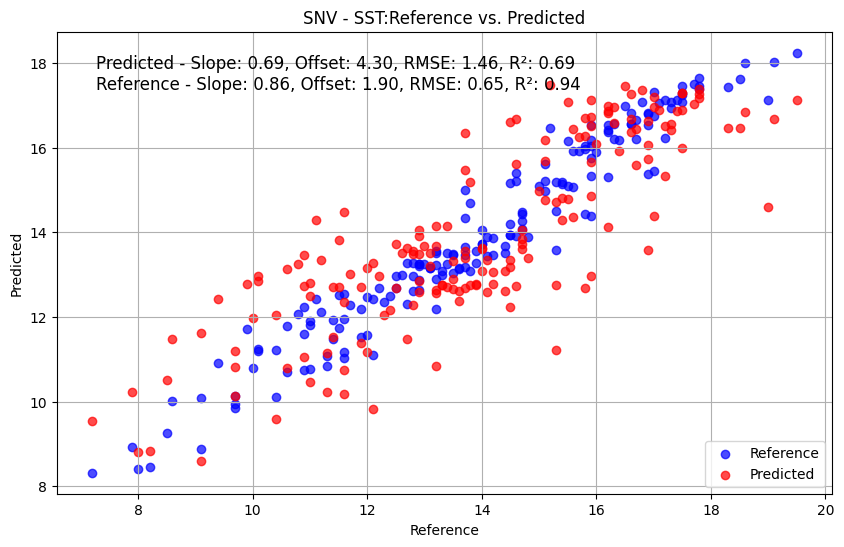

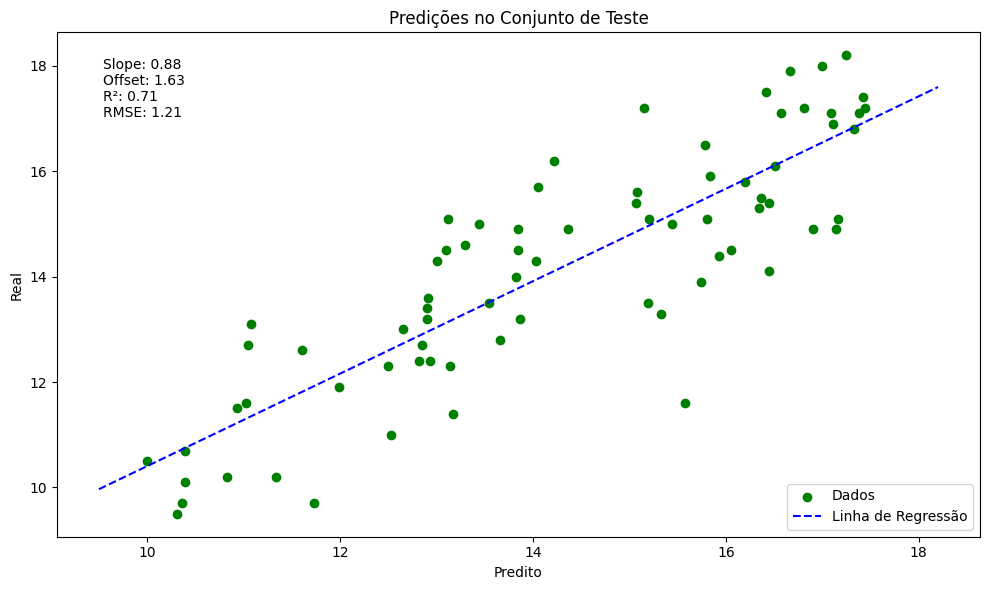

Resultados salvos em: random_forest_results.xlsx, na aba: SNV_SST


In [45]:
results_snv_sst = RFR(df_snv_cal.iloc[:, 6:], df_snv_cal['SST'].values, df_snv_val.iloc[:, 6:], df_snv_val['SST'].values, 'SNV', 'SST')
save_results('SNV', 'SST', results_snv_sst)

=== Training Metrics ===
Correlation coefficient: 0.9410
Mean absolute error: 0.1116
Root mean squared error: 0.2074
Relative absolute error: 26.4277
Root relative squared error: 37.0901
Slope: 1.1898
Offset: -0.2284
R²: 0.8624
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.6088
Mean absolute error: 0.2624
Root mean squared error: 0.4475
Relative absolute error: 62.1169
Root relative squared error: 80.0244
Slope: 0.8688
Offset: 0.1227
R²: 0.3596
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.8303
Mean absolute error: 0.1863
Root mean squared error: 0.2868
Relative absolute error: 44.3053
Root relative squared error: 55.8422
Slope: 1.0243
Offset: -0.0418
R²: 0.6882
Total Number of Instances: 75.0000


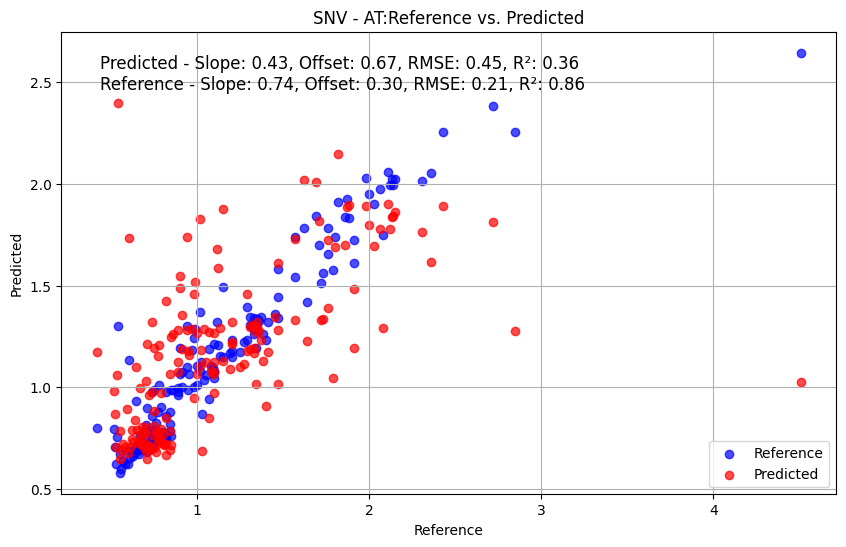

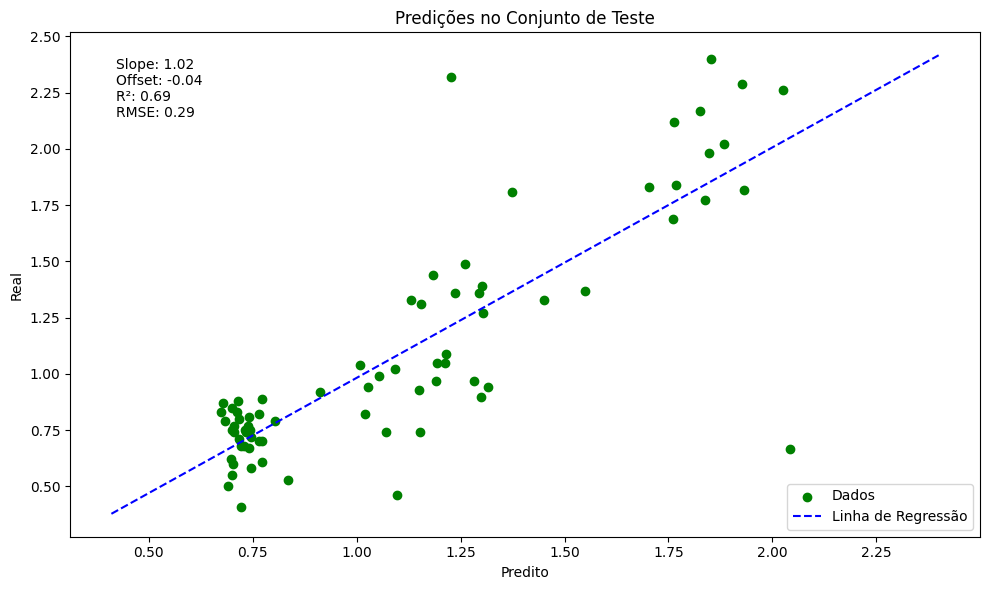

Resultados salvos em: random_forest_results.xlsx, na aba: SNV_AT


In [46]:
results_snv_at = RFR(df_snv_cal.iloc[:, 6:], df_snv_cal['AT'].values, df_snv_val.iloc[:, 6:], df_snv_val['AT'].values, 'SNV', 'AT')
save_results('SNV', 'AT', results_snv_at)

=== Training Metrics ===
Correlation coefficient: 0.9451
Mean absolute error: 0.0711
Root mean squared error: 0.1202
Relative absolute error: 28.6086
Root relative squared error: 38.3784
Slope: 1.2701
Offset: -0.8947
R²: 0.8527
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.5794
Mean absolute error: 0.1628
Root mean squared error: 0.2555
Relative absolute error: 65.4727
Root relative squared error: 81.6024
Slope: 0.9651
Offset: 0.1048
R²: 0.3341
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.7106
Mean absolute error: 0.1192
Root mean squared error: 0.1747
Relative absolute error: 56.3018
Root relative squared error: 70.7816
Slope: 0.9658
Offset: 0.0938
R²: 0.4990
Total Number of Instances: 75.0000


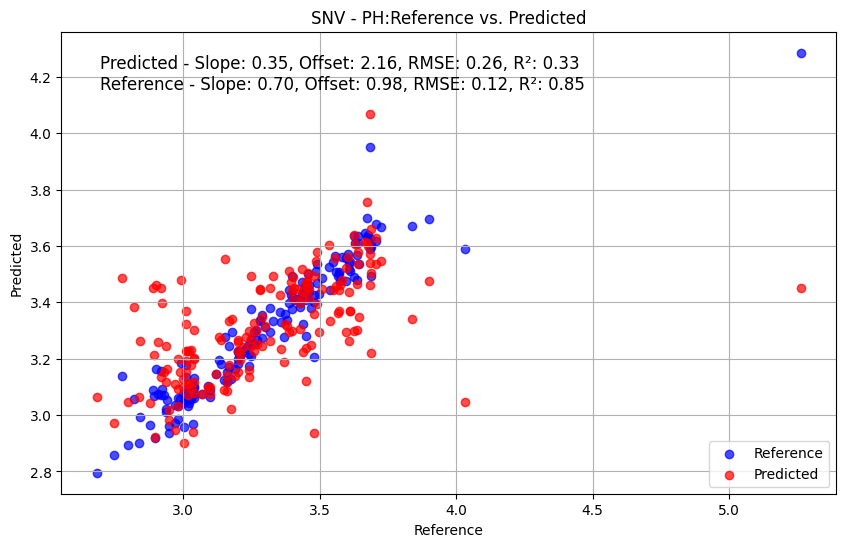

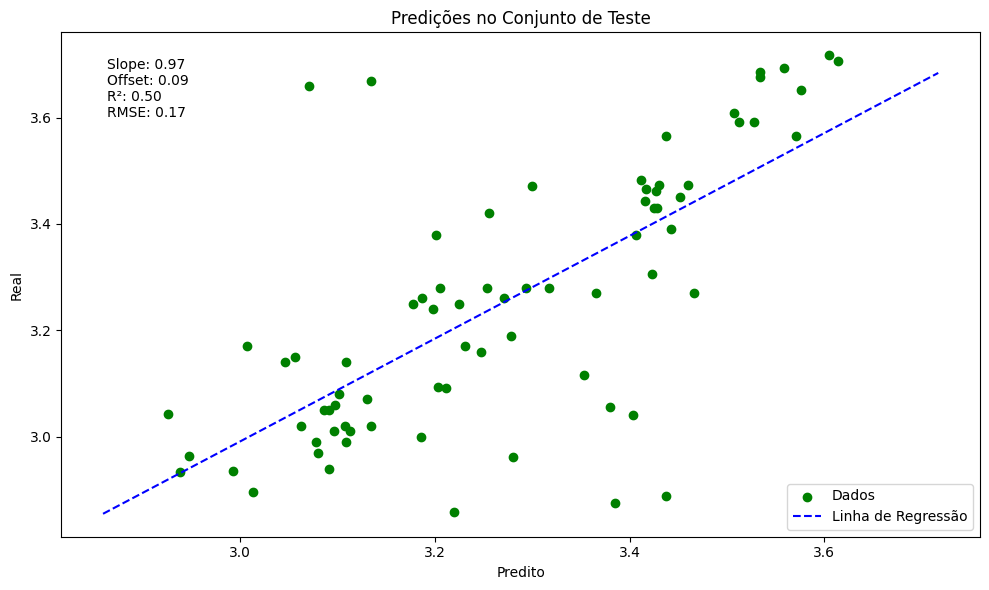

Resultados salvos em: random_forest_results.xlsx, na aba: SNV_PH


In [47]:
results_snv_ph = RFR(df_snv_cal.iloc[:, 6:], df_snv_cal['PH'].values, df_snv_val.iloc[:, 6:], df_snv_val['PH'].values, 'SNV', 'PH')
save_results('SNV', 'PH', results_snv_ph)

=== Training Metrics ===
Correlation coefficient: 0.9584
Mean absolute error: 26.4575
Root mean squared error: 33.4419
Relative absolute error: 32.7132
Root relative squared error: 33.0814
Slope: 1.2115
Offset: -109.5655
R²: 0.8906
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.6371
Mean absolute error: 62.9091
Root mean squared error: 78.0578
Relative absolute error: 77.7837
Root relative squared error: 77.2163
Slope: 0.9324
Offset: 34.0487
R²: 0.4038
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.7652
Mean absolute error: 47.4036
Root mean squared error: 54.3197
Relative absolute error: 70.6576
Root relative squared error: 66.3555
Slope: 0.9217
Offset: 28.0358
R²: 0.5597
Total Number of Instances: 75.0000


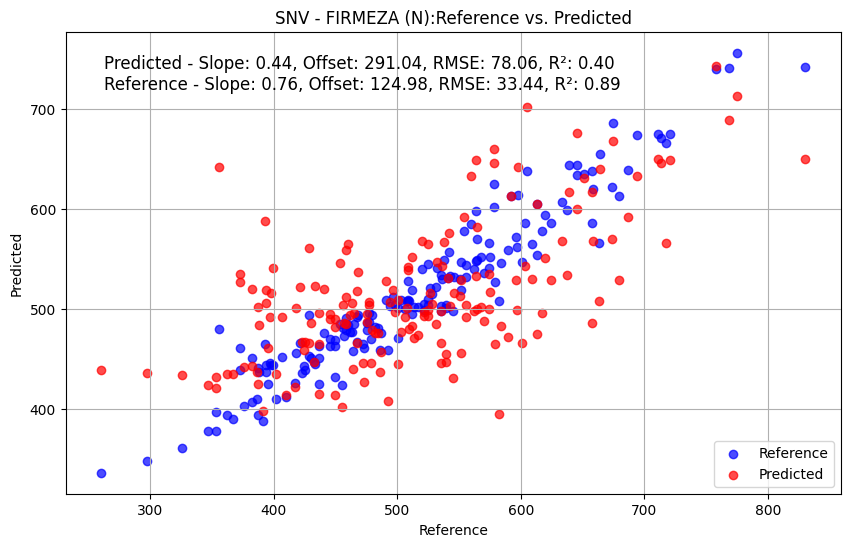

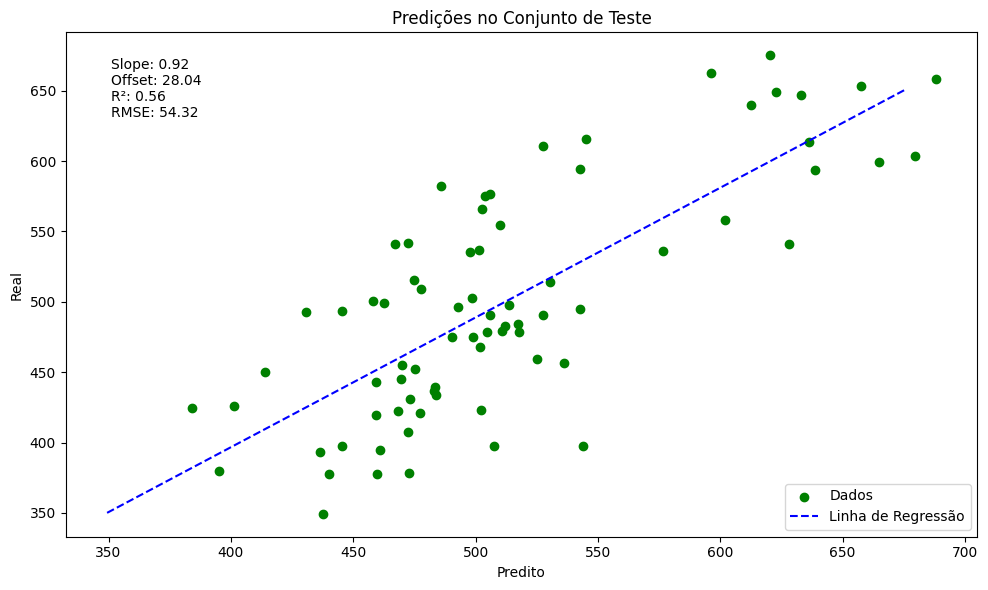

Resultados salvos em: random_forest_results.xlsx, na aba: SNV_FIRMEZA (N)


In [48]:
results_snv_firmeza = RFR(df_snv_cal.iloc[:, 6:], df_snv_cal['FIRMEZA (N)'].values, df_snv_val.iloc[:, 6:], df_snv_val['FIRMEZA (N)'].values, 'SNV', 'FIRMEZA (N)')
save_results('SNV', 'FIRMEZA (N)', results_snv_firmeza)

=== Training Metrics ===
Correlation coefficient: 0.9529
Mean absolute error: 0.5508
Root mean squared error: 1.0011
Relative absolute error: 23.0983
Root relative squared error: 31.8163
Slope: 1.1123
Offset: -1.7145
R²: 0.8988
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.7568
Mean absolute error: 1.2273
Root mean squared error: 2.0700
Relative absolute error: 51.4684
Root relative squared error: 65.7855
Slope: 0.9108
Offset: 1.3482
R²: 0.5672
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.8569
Mean absolute error: 0.9656
Root mean squared error: 1.2972
Relative absolute error: 48.8984
Root relative squared error: 54.1027
Slope: 0.8621
Offset: 1.9292
R²: 0.7073
Total Number of Instances: 75.0000


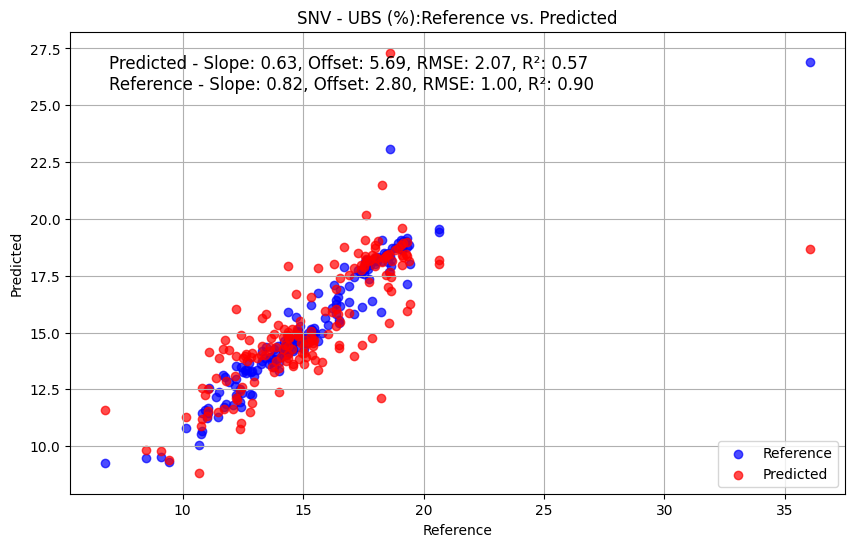

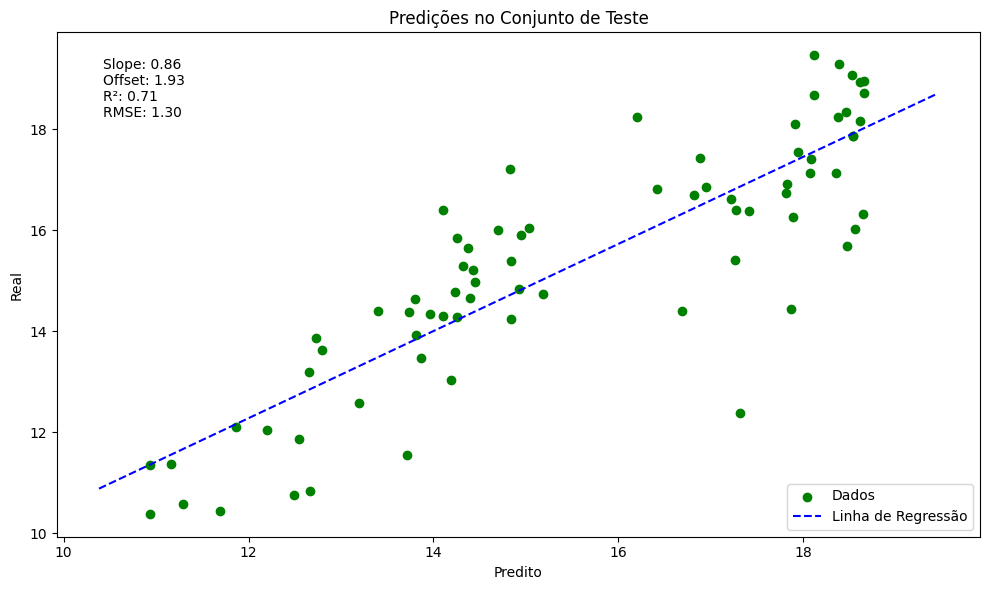

Resultados salvos em: random_forest_results.xlsx, na aba: SNV_UBS (%)


In [49]:
results_snv_ubs = RFR(df_snv_cal.iloc[:, 6:], df_snv_cal['UBS (%)'].values, df_snv_val.iloc[:, 6:], df_snv_val['UBS (%)'].values, 'SNV', 'UBS (%)')
save_results('SNV', 'UBS (%)', results_snv_ubs)

# SG - RFR

=== Training Metrics ===
Correlation coefficient: 0.9813
Mean absolute error: 0.4677
Root mean squared error: 0.5879
Relative absolute error: 21.1480
Root relative squared error: 22.1268
Slope: 1.1247
Offset: -1.7410
R²: 0.9510
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.8704
Mean absolute error: 1.0935
Root mean squared error: 1.3513
Relative absolute error: 49.4482
Root relative squared error: 50.8537
Slope: 1.1712
Offset: -2.3866
R²: 0.7414
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.8462
Mean absolute error: 0.8976
Root mean squared error: 1.1302
Relative absolute error: 52.2820
Root relative squared error: 53.7735
Slope: 0.9973
Offset: 0.1884
R²: 0.7108
Total Number of Instances: 75.0000


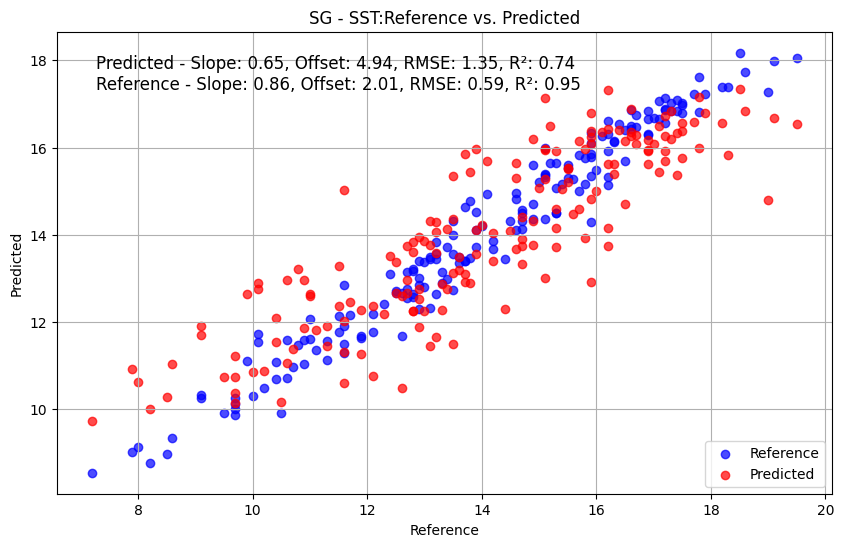

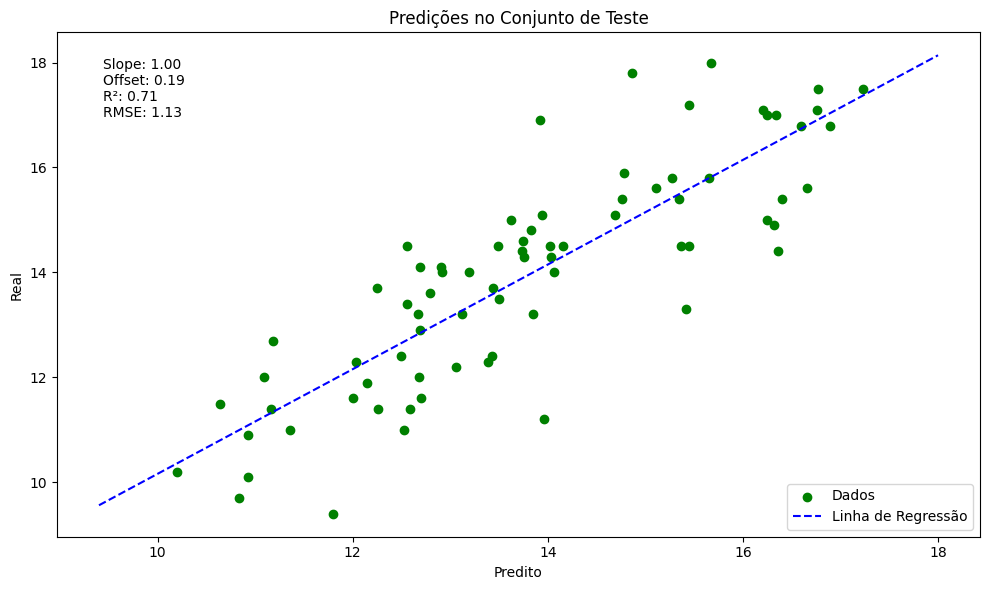

Resultados salvos em: random_forest_results.xlsx, na aba: SG_SST


In [50]:
results_sg_sst = RFR(df_sg_cal.iloc[:, 6:], df_sg_cal['SST'].values, df_sg_val.iloc[:, 6:], df_sg_val['SST'].values, 'SG', 'SST')
save_results('SG', 'SST', results_sg_sst)

=== Training Metrics ===
Correlation coefficient: 0.9623
Mean absolute error: 0.1077
Root mean squared error: 0.1900
Relative absolute error: 23.7888
Root relative squared error: 32.3850
Slope: 1.2229
Offset: -0.2547
R²: 0.8951
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.6989
Mean absolute error: 0.2447
Root mean squared error: 0.4211
Relative absolute error: 54.0785
Root relative squared error: 71.7848
Slope: 1.0851
Offset: -0.1129
R²: 0.4847
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.8202
Mean absolute error: 0.2022
Root mean squared error: 0.2612
Relative absolute error: 57.1483
Root relative squared error: 59.7875
Slope: 0.9913
Offset: -0.0656
R²: 0.6425
Total Number of Instances: 75.0000


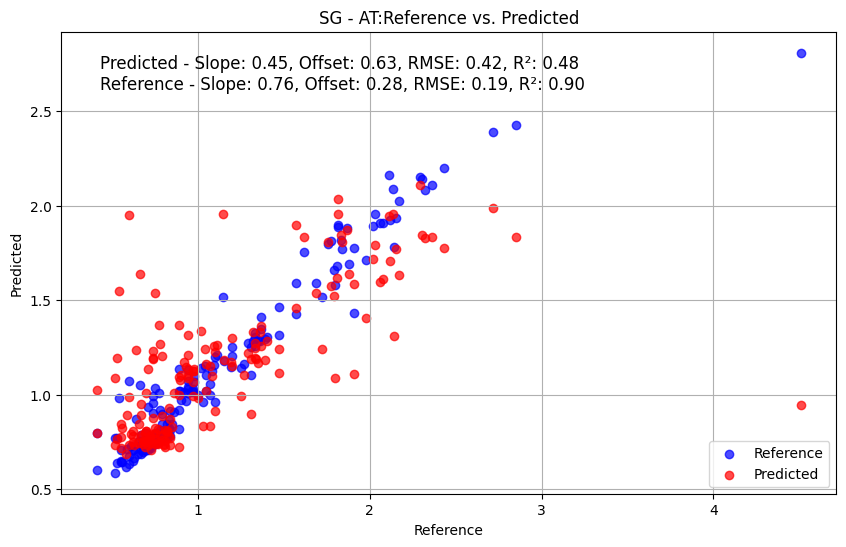

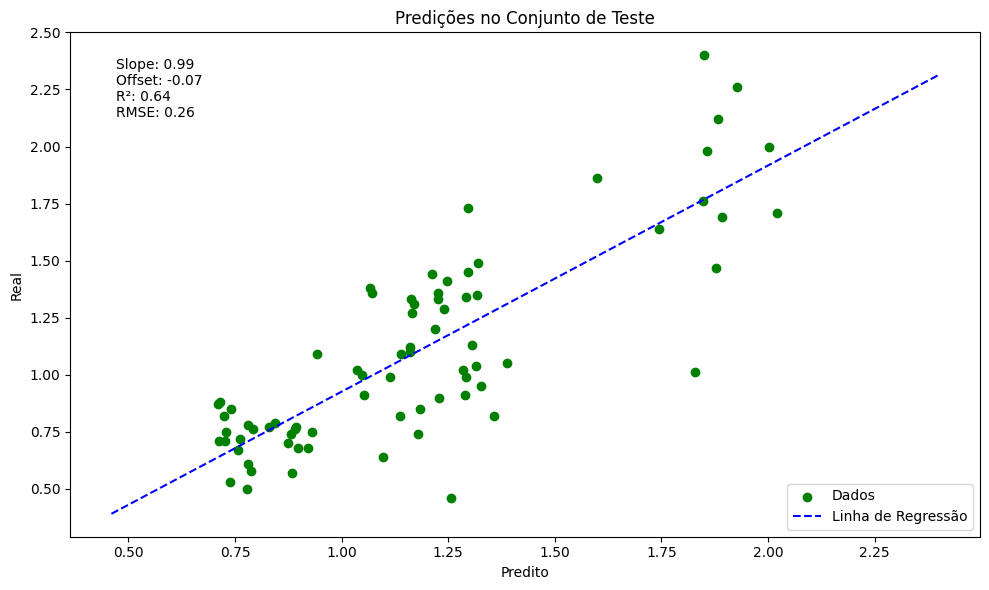

Resultados salvos em: random_forest_results.xlsx, na aba: SG_AT


In [51]:
results_sg_at = RFR(df_sg_cal.iloc[:, 6:], df_sg_cal['AT'].values, df_sg_val.iloc[:, 6:], df_sg_val['AT'].values, 'SG', 'AT')
save_results('SG', 'AT', results_sg_at)

=== Training Metrics ===
Correlation coefficient: 0.9728
Mean absolute error: 0.0608
Root mean squared error: 0.0989
Relative absolute error: 25.3042
Root relative squared error: 32.0261
Slope: 1.2945
Offset: -0.9654
R²: 0.8974
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.6026
Mean absolute error: 0.1520
Root mean squared error: 0.2473
Relative absolute error: 63.2607
Root relative squared error: 80.0348
Slope: 1.1078
Offset: -0.3590
R²: 0.3594
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.7765
Mean absolute error: 0.1211
Root mean squared error: 0.1652
Relative absolute error: 51.6734
Root relative squared error: 63.1163
Slope: 0.9750
Offset: 0.0900
R²: 0.6016
Total Number of Instances: 75.0000


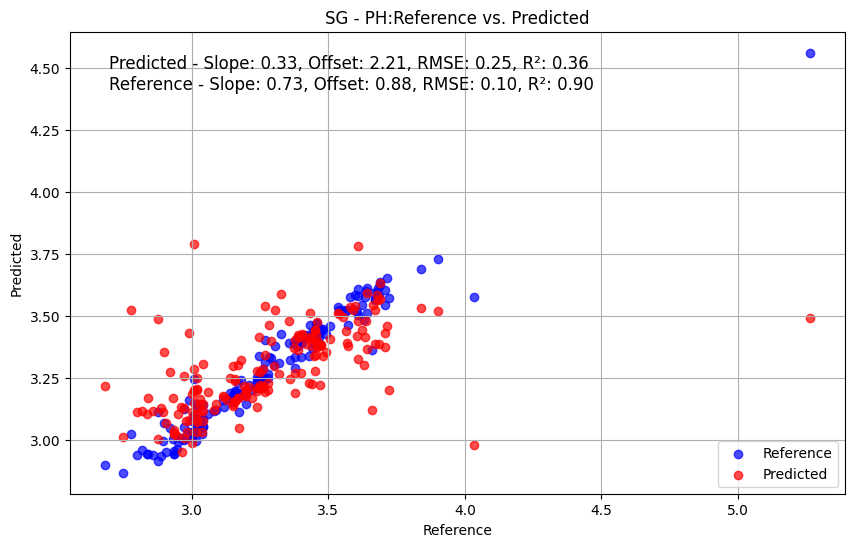

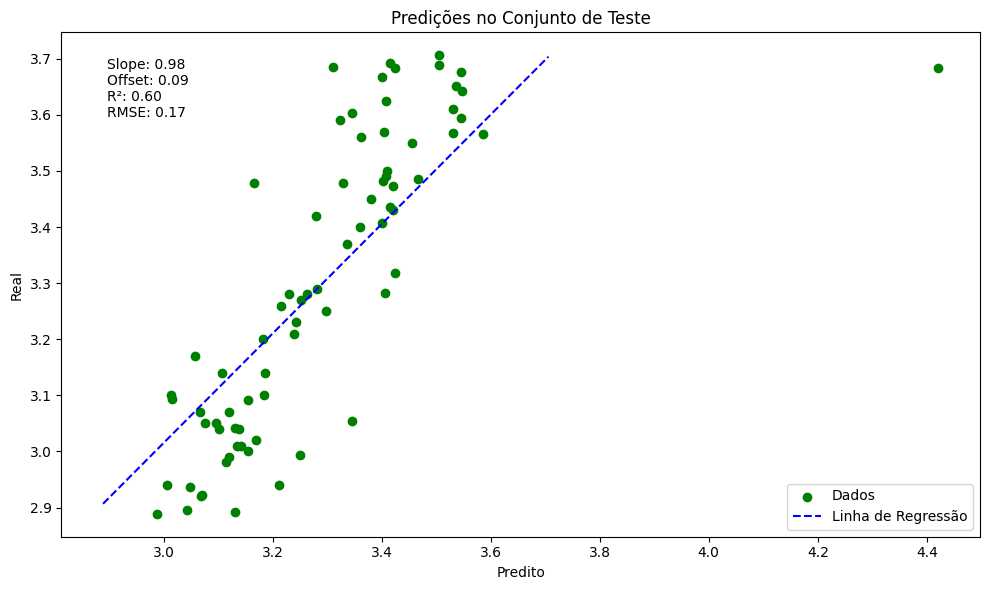

Resultados salvos em: random_forest_results.xlsx, na aba: SG_PH


In [52]:
results_sg_ph = RFR(df_sg_cal.iloc[:, 6:], df_sg_cal['PH'].values, df_sg_val.iloc[:, 6:], df_sg_val['PH'].values, 'SG', 'PH')
save_results('SG', 'PH', results_sg_ph)

=== Training Metrics ===
Correlation coefficient: 0.9674
Mean absolute error: 26.5585
Root mean squared error: 33.9731
Relative absolute error: 31.8937
Root relative squared error: 33.0568
Slope: 1.2815
Offset: -145.0367
R²: 0.8907
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.6341
Mean absolute error: 64.1858
Root mean squared error: 79.6903
Relative absolute error: 77.0797
Root relative squared error: 77.5411
Slope: 1.0988
Offset: -51.7633
R²: 0.3987
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.7492
Mean absolute error: 42.4110
Root mean squared error: 51.9789
Relative absolute error: 66.8262
Root relative squared error: 67.2854
Slope: 1.0326
Offset: -25.6317
R²: 0.5473
Total Number of Instances: 75.0000


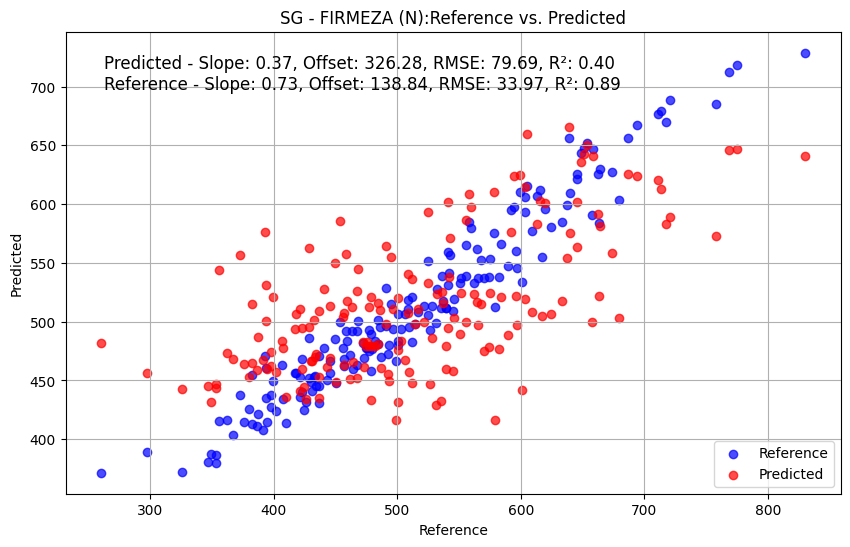

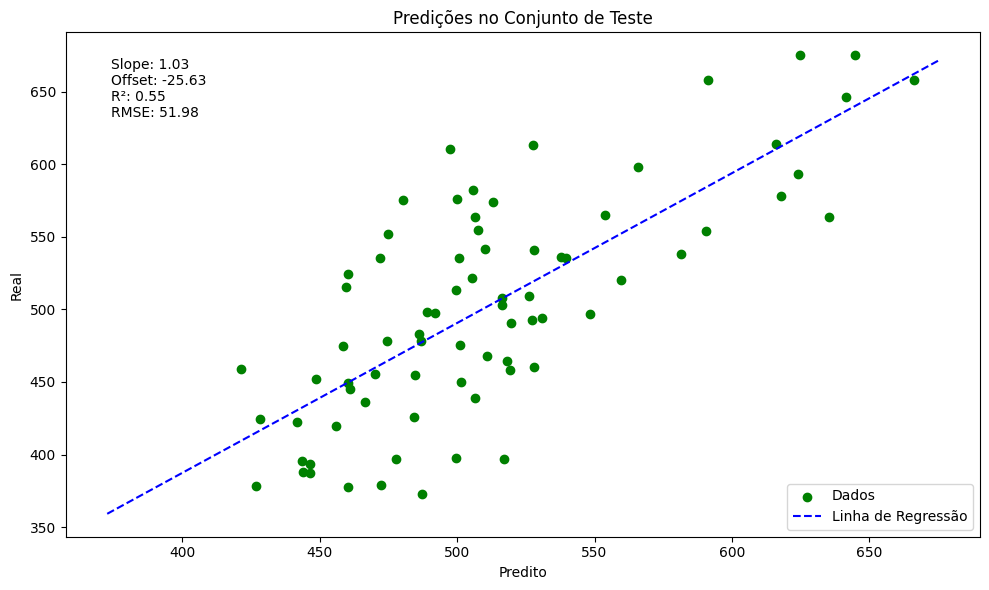

Resultados salvos em: random_forest_results.xlsx, na aba: SG_FIRMEZA (N)


In [53]:
results_sg_firmeza = RFR(df_sg_cal.iloc[:, 6:], df_sg_cal['FIRMEZA (N)'].values, df_sg_val.iloc[:, 6:], df_sg_val['FIRMEZA (N)'].values, 'SG', 'FIRMEZA (N)')
save_results('SG', 'FIRMEZA (N)', results_sg_firmeza)

=== Training Metrics ===
Correlation coefficient: 0.9644
Mean absolute error: 0.5004
Root mean squared error: 0.9563
Relative absolute error: 20.2675
Root relative squared error: 29.7310
Slope: 1.1635
Offset: -2.5051
R²: 0.9116
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.8009
Mean absolute error: 1.1057
Root mean squared error: 1.9505
Relative absolute error: 44.7791
Root relative squared error: 60.6408
Slope: 1.1353
Offset: -2.0776
R²: 0.6323
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.8844
Mean absolute error: 0.7571
Root mean squared error: 1.0266
Relative absolute error: 42.6690
Root relative squared error: 47.3735
Slope: 0.9225
Offset: 1.2409
R²: 0.7756
Total Number of Instances: 75.0000


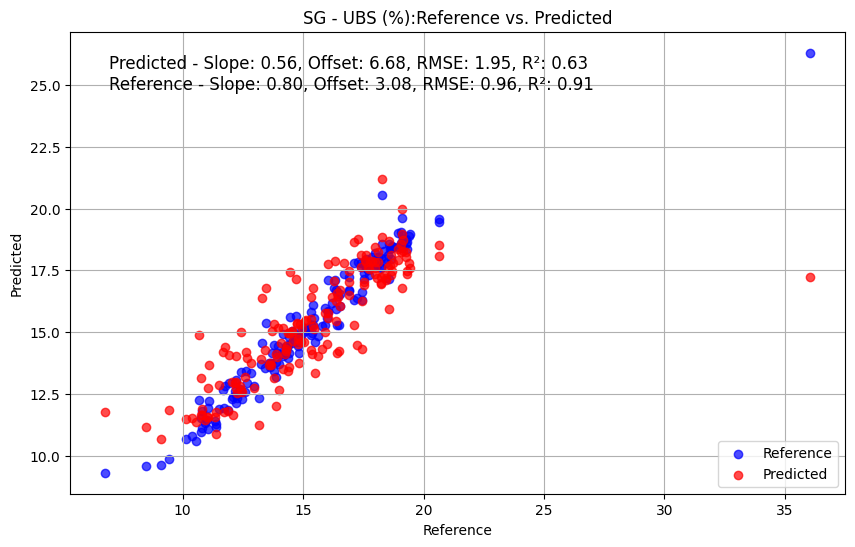

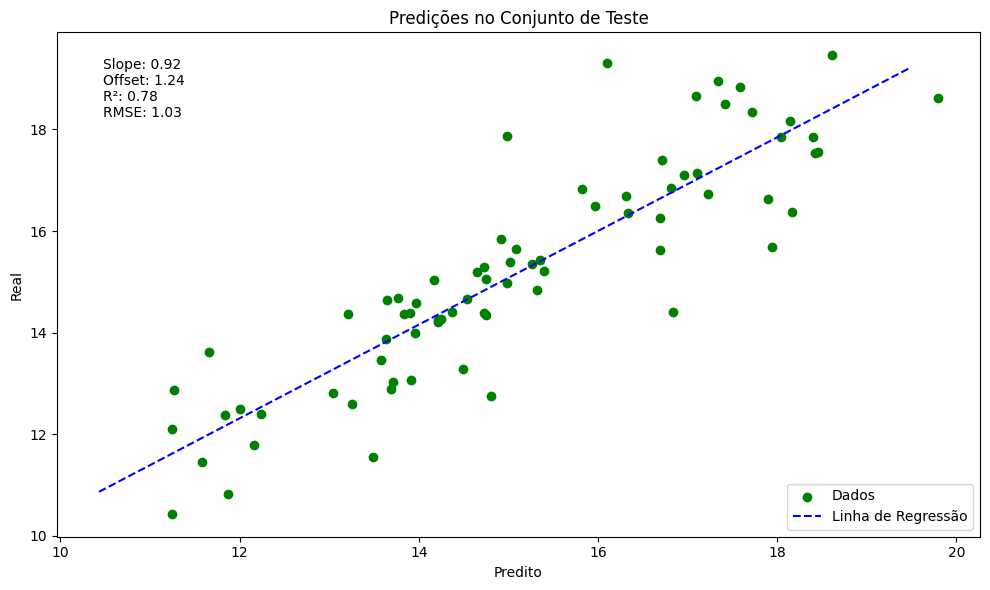

Resultados salvos em: random_forest_results.xlsx, na aba: SG_UBS (%)


In [54]:
results_sg_ubs = RFR(df_sg_cal.iloc[:, 6:], df_sg_cal['UBS (%)'].values, df_sg_val.iloc[:, 6:], df_sg_val['UBS (%)'].values, 'SG', 'UBS (%)')
save_results('SG', 'UBS (%)', results_sg_ubs)